In [2]:
!python3 -m pip install --upgrade pip
!pip install sktime pyarrow joblib scikit-learn pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 5.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.7/20.7 MB 7.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.0/38.0 MB 10.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 12.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.5/502.5 kB 12.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 15.0 MB/s eta 0:00:0000:0100:01


In [27]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.2/156.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 70.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.7/310.7 kB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 66.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 122.9 MB/s eta 0:00:00


In [4]:
import pandas as pd

In [5]:
df = pd.read_feather('../data/df_btc_with_features_5m_spot.feather')

df['target'] = df['close'].pct_change(1)
df = df.dropna(subset = ['target'], axis = 0)
start_time = df['open_time'].min()
end_time = df['open_time'].max()
dates = df['open_time'].unique()
n = len(dates)
train_idx = int(0.7 * n)
valid_idx = int(0.9 * n)
train_end = dates[train_idx]
valid_end = dates[valid_idx]

train_df = df.loc[df['open_time'] < train_end].reset_index(drop=True)
valid_df = df.loc[(train_end <= df['open_time']) & (df['open_time'] < valid_end)].reset_index(drop=True)

# train_df = pd.concat([train_df, valid_df], axis = 0)

# test_df = df.loc[(df['open_time'] >= valid_end)].reset_index(drop=True)
# valid_df = test_df.copy()

In [6]:
window = 30
file = f'target_30m_feature.csv'
corr = pd.read_csv(f'../output/feature_corr/{file}', header = 0, index_col = 0)

In [7]:
train_features = corr.iloc[:50].index.tolist()

In [8]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.ltsf import LTSFLinearForecaster 
from sktime.regression.deep_learning.cnn import CNNRegressor

In [9]:
def normalize_float_columns(df, features):
  float_cols = df[features].select_dtypes(include = [float]).columns
  means = df[float_cols].mean().astype('float32')
  std = df[float_cols].std().astype('float32')
  df[float_cols] = df[float_cols].ffill().fillna(means)
  df[float_cols] = (df[float_cols] - means) / std
  return df, means, std

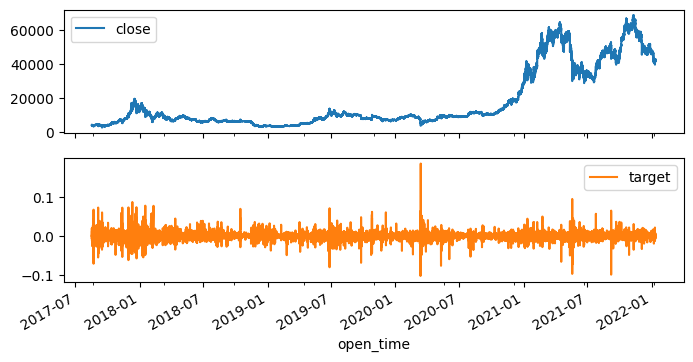

In [28]:
ax = train_df.plot(x = 'open_time', y = ['close', 'target'], subplots = True, sharex = True, figsize = (8, 4))

## Naive

In [43]:
model = LTSFLinearForecaster(seq_len = 300, pred_len = 100, 
                             num_epochs = 10, batch_size = 64)

In [45]:
model.fit(y, fh = fh)

LTSFLinearForecaster(batch_size=64, num_epochs=10, pred_len=100, seq_len=300)

In [48]:
ypred = model.predict(

ValueError: A different forecasting horizon `fh` has been provided from the one seen already in `fit`, in this instance of LTSFLinearForecaster. If you want to change the forecasting horizon, please re-fit the forecaster. This is because fitting of the forecaster LTSFLinearForecaster depends on `fh`. 

In [47]:
ypred

461647   -0.000467
461648   -0.000142
461649   -0.000460
461650   -0.000321
461651   -0.000184
            ...   
461742    0.000011
461743   -0.000290
461744   -0.000057
461745   -0.000025
461746   -0.000188
Name: target, Length: 100, dtype: float32

In [11]:
X, means, std = normalize_float_columns(train_df, train_features)

In [23]:
import numpy as np
from sktime.forecasting.naive import NaiveForecaster
fh = np.arange(1, 101)

In [24]:
y = train_df['target']

In [22]:
naive = NaiveForecaster(strategy = 'last')


In [41]:
from sktime.registry import all_estimators

forecaster_list = all_estimators(filter_tags={"ignores-exogeneous-X": 0}, as_dataframe = True)

In [42]:
forecaster_list

,name,object
0,ARDL,<class 'sktime.forecasting.ardl.ARDL'>
1,ARIMA,<class 'sktime.forecasting.arima.ARIMA'>
2,AutoARIMA,<class 'sktime.forecasting.arima.AutoARIMA'>
3,AutoEnsembleForecaster,<class 'sktime.forecasting.compose._ensemble.A...
4,AutoREG,<class 'sktime.forecasting.auto_reg.AutoREG'>
5,ColumnEnsembleForecaster,<class 'sktime.forecasting.compose._column_ens...
6,ConformalIntervals,<class 'sktime.forecasting.conformal.Conformal...
7,Croston,<class 'sktime.forecasting.croston.Croston'>
8,DirectTabularRegressionForecaster,<class 'sktime.forecasting.compose._reduce.Dir...
9,DirectTimeSeriesRegressionForecaster,<class 'sktime.forecasting.compose._reduce.Dir...
